In [1]:
import open3d as o3d
import numpy as np
from numpy.random import default_rng
from matplotlib import pyplot as plt
import os
import cv2
import random
import sys
import math
import random
from time import sleep
import matplotlib.pyplot as plt
import copy
# monkey patches visualization and provides helpers to load geometries
#sys.path.append('..')
#import open3d_tutorial as o3dtut
# change to True if you want to interact with the visualization windows
#o3dtut.interactive = not "CI" in os.environ

# RANSAC experiment

## Utilities

In [2]:
def find_hull(points):
    
    inliers_pcd = o3d.geometry.PointCloud()
    inliers_pcd.points = o3d.utility.Vector3dVector(points)
    #print(type(inliers_pcd))
    hull, _ = inliers_pcd.compute_convex_hull()
    hull_ls = o3d.geometry.LineSet.create_from_triangle_mesh(hull)
    color = np.random.rand(3).tolist()
    hull_ls.paint_uniform_color(color)
    return hull_ls


In [3]:
def color_pts(points):
    inliers_pcd = o3d.geometry.PointCloud()
    inliers_pcd.points = o3d.utility.Vector3dVector(points)
    color = np.random.rand(3)
    #color = np.array([0,0,0])
    point_colors = np.tile(color, (points.shape[0],1))
    inliers_pcd.colors = o3d.utility.Vector3dVector(point_colors)
    return inliers_pcd

## Find plane

In [4]:
class plane:
    def __init__(self, M0, M1, M2):
        A0 = np.linalg.det(np.array([[M1[1]-M0[1],M2[1]-M0[1]],[M1[2]-M0[2],M2[2]-M0[2]]]))
        A1 = np.linalg.det(np.array([[M1[0]-M0[0],M2[0]-M0[0]],[M1[2]-M0[2],M2[2]-M0[2]]]))
        A2 = np.linalg.det(np.array([[M1[0]-M0[0],M2[0]-M0[0]],[M1[1]-M0[1],M2[1]-M0[1]]]))
        self.A = A0
        self.B = -A1
        self.C = A2
        self.D = -M0[0]*A0+M0[1]*A1-M0[2]*A2
    def calc_dist(self, pcd):
        R = np.absolute(self.A*pcd[:,0]+self.B*pcd[:,1]+self.C*pcd[:,2]+self.D)/(np.sqrt(self.A**2+self.B**2+self.C**2)+ sys.float_info.epsilon)
        #print(type(R))
        return R

In [5]:
def find_pts_plane(pcd):
    indexA = np.random.randint(0,pcd.shape[0])
    A = pcd[indexA]
    #print(A)
    distancesA = np.sqrt((pcd[:,0] - A[0])**2+(pcd[:,1] - A[1])**2+ (pcd[:,2] - A[2])**2)
    
    #Calculating B probabilities
    roundedA = np.around(distancesA,1)
    uniqueB, countsB = np.unique(roundedA, return_counts = True)
    probabilitiesB =1 - countsB/distancesA.shape[0]
    probabilitiesB /= probabilitiesB.sum()
    #plt.plot(uniqueB, probabilitiesB)
    #plt.show()
    choose_thresholded_value_B = np.random.choice(uniqueB, p=probabilitiesB)
    B_candidate_indices = np.argwhere(roundedA==choose_thresholded_value_B)
    B_candidate_indices = B_candidate_indices.reshape(B_candidate_indices.shape[0])
    indexB = np.random.choice(B_candidate_indices)
    B = pcd[indexB]
    #print(B)
    #print(np.sqrt((B[0] - A[0])**2+(B[1] - A[1])**2+ (B[2] - A[2])**2))
    
    pcd = np.delete(pcd, [indexA,indexB],0) 
    #pcd = np.delete(pcd, indexB,0)
   
    
    #Calculating C probabilities
    mid_AB = np.array([(A[0]+B[0])/2,(A[1]+B[1])/2,(A[2]+B[2])/2])
    distances_mid_AB = np.sqrt((pcd[:,0] - mid_AB[0])**2+(pcd[:,1] - mid_AB[1])**2+ (pcd[:,2] - mid_AB[2])**2)
    roundedAB = np.around(distances_mid_AB,1)
    uniqueC, countsC = np.unique(roundedAB, return_counts = True)
    probabilitiesC =1- countsC/distances_mid_AB.shape[0]
    
    probabilitiesC /= probabilitiesC.sum()
    #plt.plot(uniqueC, probabilitiesC)
    #plt.show()
    choose_thresholded_value_C = np.random.choice(uniqueC, p=probabilitiesC)
    C_candidate_indices = np.argwhere(roundedAB==choose_thresholded_value_C)
    C_candidate_indices = C_candidate_indices.reshape(C_candidate_indices.shape[0])
    indexC = np.random.choice(C_candidate_indices)
    C = pcd[indexC]
    #print(C)
    
    return A, B, C
   

In [6]:
def find_plane(pcd, iterations, threshold):
    best_fit = 0############## убрать костыль
    best_inliers_pts = np.zeros([1,3])
    best_inlier_indices = None
    inliers = None
    best_model = list()
    for i in range(iterations):
        A, B, C = find_pts_plane(np.asarray(pcd.points))
        p = plane(A,B,C)
        R = p.calc_dist(np.asarray(pcd.points))
        inliers = np.where(R<=threshold)[0]
        inliers_len = inliers.shape[0] +3
        inliers_pts = np.take(np.asarray(pcd.points),inliers,axis=0)
        outliers = np.asarray(pcd.points).shape[0] - inliers_len
        fit = inliers_len/outliers
        if fit>best_fit:
            best_fit = fit
            print('Found better fintess: ',best_fit, 'at', i )
            best_model = [A,B,C]
            best_inliers_pts = inliers_pts
            best_inlier_indices = inliers
    return best_model, best_inliers_pts, best_inlier_indices

## Find sphere

In [7]:
class sphere:
    def __init__(self, p1, p2, v1, v2):
        
        self.center = 0
        self.radius = 0.001
        unit_v1 = v1 / np.linalg.norm(v1)
        unit_v2 = v2 / np.linalg.norm(v2)
        dot_product = np.dot(unit_v1, unit_v2)
        angle = np.degrees(np.arccos(dot_product))
        self.accept_shape = True
        a1 = np.dot(p2,v1)-np.dot(p1,v1)
        a2 = np.dot(p2,v2)-np.dot(p1,v2)
        b1 = np.dot(v2,v1)
        b2 = np.dot(v2,v2)
        c1 = np.dot(v1,v1)
        c2 = np.dot(v1,v2)
        A = np.array([[b1,-c1],[b2,-c2]])
        #print(A)
        B = np.array([-a1,-a2])
        #print('A=', A,'B=', B)
        try:
            C = np.linalg.solve(A,B)
            P = p1 + C[1]*v1
            Q = p2 + C[0]*v2
            self.center = (P+Q)/2
            r1 = np.linalg.norm(self.center-p1)
            r2 = np.linalg.norm(self.center-p2)
            self.radius = (r1+r2)/2
            self.accept_shape = True
        except:
            
            self.accept_shape = False
        #print(C)
        if angle>=180.0:
            self.accept_shape = False
            
        
        
        
    def calc_dist(self, pcd):
        #R = 
        R = np.linalg.norm(self.center-pcd, axis=-1)
        #print(R)
        #print(type(R))
        return R
    
    

In [8]:
def visualize_sphere(center,radius):
    sphere_mesh = o3d.geometry.TriangleMesh.create_sphere(radius, resolution = 20)
    
    sphere_mesh = sphere_mesh.translate(center)
    lineset = o3d.geometry.LineSet.create_from_triangle_mesh(sphere_mesh)
    return lineset

In [9]:
def find_pts_sphere(pcd):
    o3d.geometry.PointCloud.estimate_normals(
        pcd,
        search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1,
                                                          max_nn=30))
    pcd1 = np.asarray(pcd.points)
    indexA = np.random.randint(0,pcd1.shape[0])
    A = pcd1[indexA]
    #print(A)
    distancesA = np.sqrt((pcd1[:,0] - A[0])**2+(pcd1[:,1] - A[1])**2+ (pcd1[:,2] - A[2])**2)
    
    #Calculating B probabilities
    roundedA = np.around(distancesA,1)
    uniqueB, countsB = np.unique(roundedA, return_counts = True)
    probabilitiesB =1 - countsB/distancesA.shape[0]
    probabilitiesB /= probabilitiesB.sum()
    #print(probabilitiesB)
    #plt.plot(uniqueB, probabilitiesB)
    #plt.show()
    choose_thresholded_value_B = np.random.choice(uniqueB, p=probabilitiesB)
    B_candidate_indices = np.argwhere(roundedA==choose_thresholded_value_B)
    B_candidate_indices = B_candidate_indices.reshape(B_candidate_indices.shape[0])
    indexB = np.random.choice(B_candidate_indices)
    B = pcd1[indexB]
    v1 = pcd.normals[indexA]
    v2 = pcd.normals[indexB]
    
    return A,B,v1,v2

In [10]:
def find_sphere(pcd, iterations, threshold):
    best_fit = 0
    best_inliers_pts = np.zeros
    best_inlier_indices = None
    inliers = None
    best_center = np.array((0,0,0))
    best_radius = 0.001
    angle = 0
    for j in range(iterations):
        #print(i)
        for i in range(5):
            p1,p2,v1,v2 = find_pts_sphere(pcd)
            s = sphere(p1,p2,v1,v2)
            
            if s.accept_shape==True:
                break
            
            print('Restart')
        #print(s.radius)
        R = s.calc_dist(np.asarray(pcd.points))
        #print(R)
        inliers = np.where((R<=s.radius+threshold) & (R>s.radius-threshold))[0] ################
        #inliers = R[R-s.radius-threshold-threshold/2.<threshold/2.]
        inliers_len = inliers.shape[0] +3
        #print(inliers)
        inliers_pts = np.take(np.asarray(pcd.points),inliers,axis=0)
        #print(inliers)
        outliers = np.asarray(pcd.points).shape[0] - inliers_len
        #print(outliers)
        fit = inliers_len/outliers
        if fit>best_fit:
            best_fit = fit
            print('Found better fintess: ',best_fit, 'at', j )
            best_center = s.center
            best_radius = s.radius
            best_inliers_pts = inliers_pts
            best_inlier_indices = inliers
    return best_center, best_radius, best_inliers_pts, best_inlier_indices

## Main

RGBDImage of size 
Color image : 640x480, with 1 channels.
Depth image : 640x480, with 1 channels.
Use numpy.asarray to access buffer data.


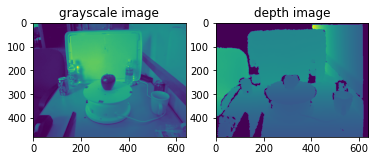

PointCloud with 251818 points.
Found better fintess:  0.026986023711159417 at 0
Found better fintess:  0.03558914970966097 at 2
Found better fintess:  0.04416008757380747 at 5
Found better fintess:  0.06704350921202054 at 7
Found better fintess:  0.16165609502940836 at 10
Found better fintess:  0.21942810101450327 at 13
Found better fintess:  0.3731133310068051 at 23
PointCloud with 183395 points.
Found better fintess:  0.049957347898024265 at 0
Found better fintess:  0.060313477448934165 at 2
Found better fintess:  0.07305642183852225 at 11
Found better fintess:  0.08110258964730571 at 12
Found better fintess:  0.0942683596267214 at 42
PointCloud with 167599 points.
Found better fintess:  0.060249881385418314 at 0
Found better fintess:  0.07029094717482375 at 5
Found better fintess:  0.07129662181597367 at 7
Found better fintess:  0.12658721356214753 at 8
Found better fintess:  0.19029999147751483 at 18
PointCloud with 140807 points.
Found better fintess:  0.045679360741444866 at 0
Fo

In [15]:
#pcd = o3d.io.read_point_cloud("models/cube_test1.ply")
#pcd = o3d.io.read_point_cloud("models/mball.ply")
#pcd = o3d.io.read_point_cloud("models/fragment.ply") 
#pcd = o3d.io.read_point_cloud("aivisum.ply")
#pcd = o3d.io.read_point_cloud("models/ballcube.ply")

color_raw = o3d.io.read_image("models/apple_1_1_12.png")
depth_raw = o3d.io.read_image("models/apple_1_1_12_depth.png")
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color_raw, depth_raw)
print(rgbd_image)
plt.subplot(1, 2, 1)
plt.title('grayscale image')
plt.imshow(rgbd_image.color)
plt.subplot(1, 2, 2)
plt.title('depth image')
plt.imshow(rgbd_image.depth)
plt.show()
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image,
    o3d.camera.PinholeCameraIntrinsic(
        o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault))
# Flip it, otherwise the pointcloud will be upside down

#pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])





vis = o3d.visualization.Visualizer()
vis.create_window(width = 800, height = 600)
vis.add_geometry(pcd)

print(pcd)
models_list = []
inliers_list = []

##find planar 

for i in range(4):
    model, inliers, inliers_indices = find_plane(pcd,50,0.009)
    if inliers.shape[0]>15:
        pts = color_pts(inliers)
        vis.add_geometry(pts)
        pcd.points = o3d.utility.Vector3dVector(np.delete(np.asarray(pcd.points), inliers_indices,0))
        print(pcd)

##find spherical

for i in range(1):
    center, radius, inliers, inliers_indices = find_sphere(pcd,50,0.009)
    mesh = visualize_sphere(center,radius)
    vis.add_geometry(mesh)
    if type(inliers)!='NoneType':
        if inliers.shape[0]>0:
            
            pts = color_pts(inliers)
            vis.add_geometry(pts)
            pcd.points = o3d.utility.Vector3dVector(np.delete(np.asarray(pcd.points), inliers_indices,0))
            print(pcd)





color = np.array([0,0,0])
point_colors = np.tile(color, (np.asarray(pcd.points).shape[0],1))
colors = o3d.utility.Vector3dVector(point_colors)
#point_colors = np.tile(color, (points.shape[0],1))
pcd.colors = o3d.utility.Vector3dVector(point_colors)
vis.run()
vis.destroy_window()

In [ ]:
for i in range(7):
    print (i)

In [80]:
np.zeros([1,3])

array([[0., 0., 0.]])